# MNIST Normal
This note book uses convolutional neural networks to read mnist images. We then visualize the weight matrices.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms

In [2]:
# download mnist data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

# create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle=True)


In [3]:
# small network for mnist
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_sm = nn.Conv2d(1, 4, 3, padding='same') # 28x28x1 -> 28x28x4
        self.conv1_md = nn.Conv2d(1, 4, 5, padding='same') # 28x28x1 -> 28x28x4
        self.conv1_lg = nn.Conv2d(1, 4, 7, padding='same') # 28x28x1 -> 28x28x4
        self.maxpool1 = nn.MaxPool2d(2) # 28x28x12 -> 14x14x12
        self.conv2 = nn.Conv2d(12, 20, 3) # 14x14x12 -> 12x12x20
        self.fc1 = nn.Linear(12*12*20, 128) # 12x12x20 -> 128
        self.fc2 = nn.Linear(128, 10) # 128 -> 10

    
    
    def forward(self, x):
        x_sm = F.relu(self.conv1_sm(x))
        x_md = F.relu(self.conv1_md(x))
        x_lg = F.relu(self.conv1_lg(x))
        x = torch.cat((x_sm, x_md, x_lg), dim=1)
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create model
model = Net().to(device)

# create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
# train model
epochs = 20
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # move tensors to device
        images, labels = images.to(device), labels.to(device)

        # clear gradients
        optimizer.zero_grad()

        # forward pass
        output = model(images)

        # calculate loss
        loss = F.cross_entropy(output, labels)

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()

        running_loss += loss.item()

    print(f"Training loss: {running_loss/len(train_loader)}")

Training loss: 0.414286052990467
Training loss: 0.11220253327108444
Training loss: 0.06961648181239341
Training loss: 0.051651691776165305
Training loss: 0.04131195848371754
Training loss: 0.03363542399032319
Training loss: 0.0284537624508301


KeyboardInterrupt: 

In [6]:
# test model
test_loss = 0
accuracy = 0
with torch.no_grad():
    for images, labels in test_loader:
        # move tensors to device
        images, labels = images.to(device), labels.to(device)

        # forward pass
        output = model(images)

        # calculate loss
        test_loss += F.cross_entropy(output, labels).item()

        # calculate accuracy
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

print(f"Test loss: {test_loss/len(test_loader)}")
print(f"Test accuracy: {accuracy/len(test_loader)}")

Test loss: 0.03491524268174544
Test accuracy: 0.98828125


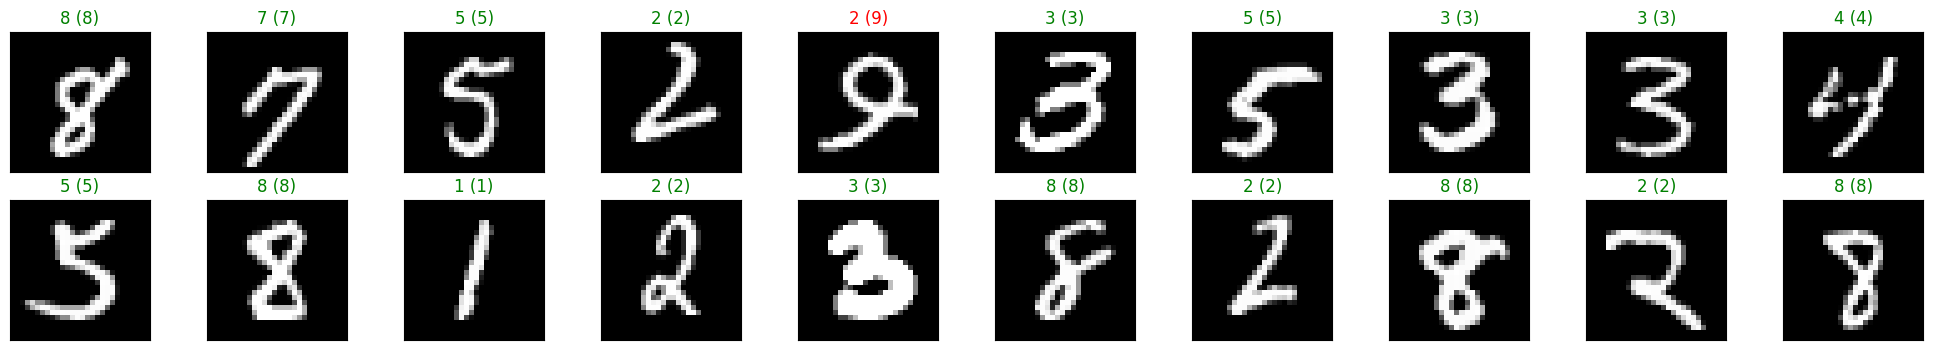

In [7]:
# show some examples
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(f"{preds[idx]} ({labels[idx]})",
                 color=("green" if preds[idx]==labels[idx] else "red"))

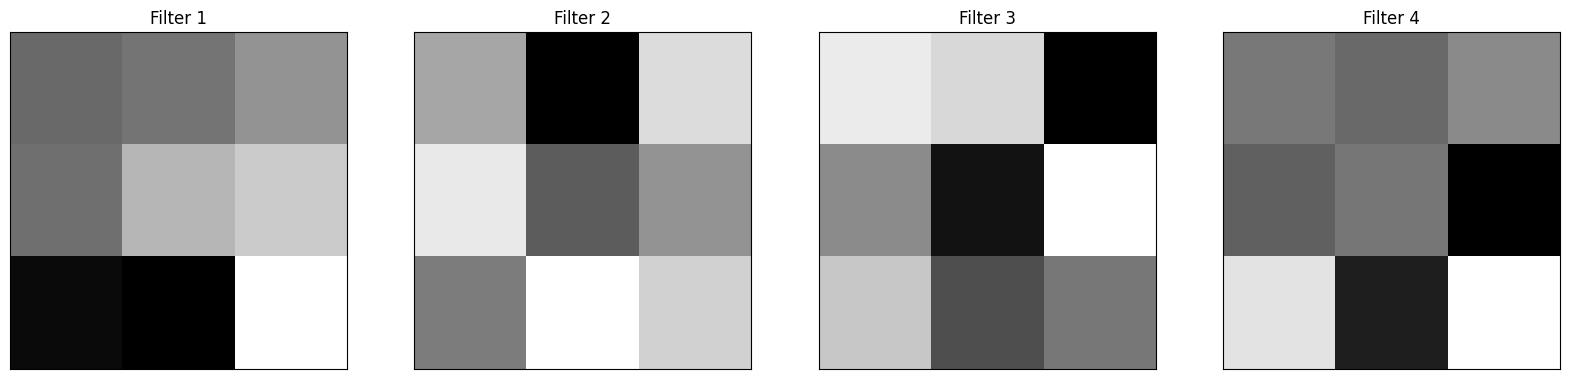

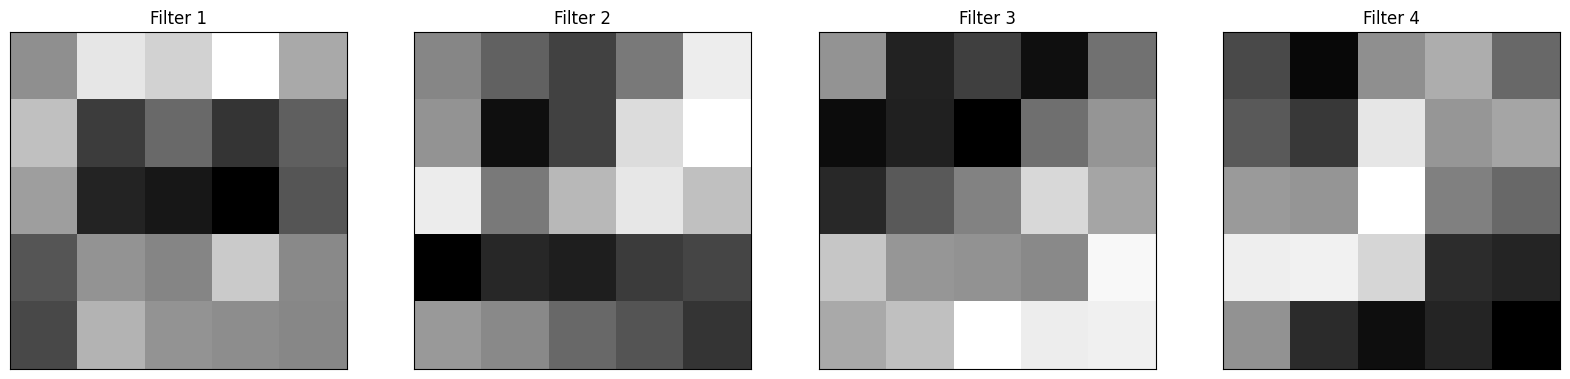

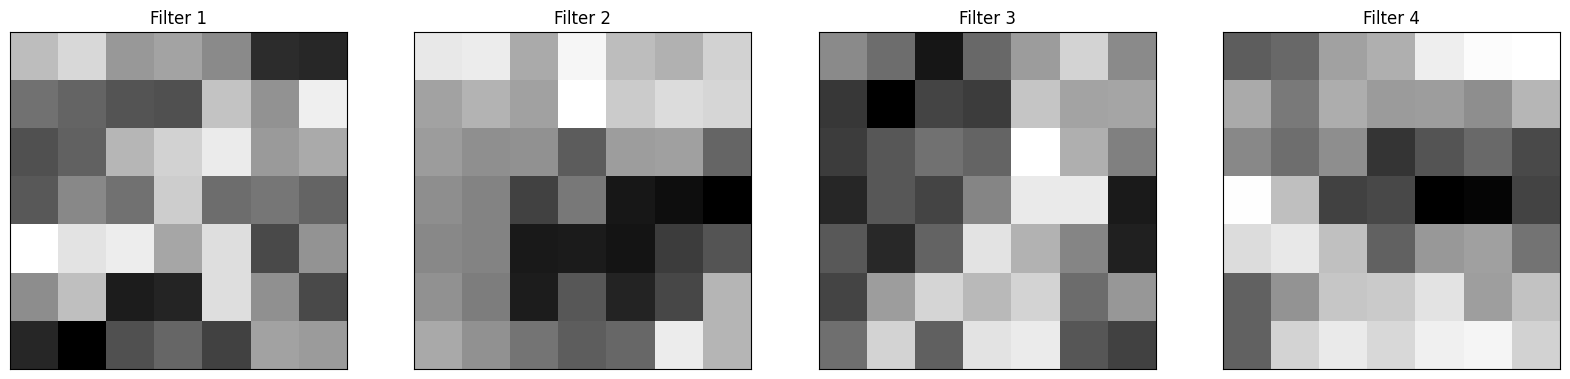

In [11]:
# view the filters of the small convolutional layer
fig = plt.figure(figsize=(20, 8))
for idx in range(4):
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(model.conv1_sm.weight[idx].cpu().detach().numpy()), cmap='gray')
    ax.set_title(f"Filter {idx+1}")

# view the filters of the medium convolutional layer
fig = plt.figure(figsize=(20, 8))
for idx in range(4):
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(model.conv1_md.weight[idx].cpu().detach().numpy()), cmap='gray')
    ax.set_title(f"Filter {idx+1}")

# view the filters of the large convolutional layer
fig = plt.figure(figsize=(20, 8))
for idx in range(4):
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(model.conv1_lg.weight[idx].cpu().detach().numpy()), cmap='gray')
    ax.set_title(f"Filter {idx+1}")